# Практическое задание.

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn import model_selection
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

### Задание 3:

*Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [4]:
def gb_predict(X, trees_list, eta):
    
    ### ИЗМЕНЕНИЯ
    # в алгоритме из лекции мы зачем-то предсказывали отдельно каждый объект из всей выборки.
    # Сейчас же предсказание идет сразу на всю выборку.
    predictions = np.array(
        sum([eta * tree.predict(X) for tree in trees_list])
    )
    
    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [6]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [9]:
def get_error_plot_ntrees(n_trees, train_err, test_err):
    plt.xlabel('n trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show();

### Задание 1.
Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

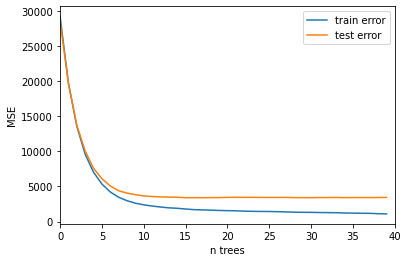

In [10]:
#n_trees = np.arange(1, 50, 1)
n_trees = 40
max_depth = 3
eta = 0.2

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
get_error_plot_ntrees(n_trees, train_errors, test_errors)

Резкое уменьше ошибки на тесте и на трейне с 1 до 5 деревьев в бустинге, затем ошибка на тесте выходит на ассимптоту с 5 до 10 деревьев, а далее даже немного увеличивается. На трейне же ошибка медленно стремится к нулю, но, так как отметили ранее, на тесте в этот же момент ошибка тихонько растет, что говорит о переобучении.

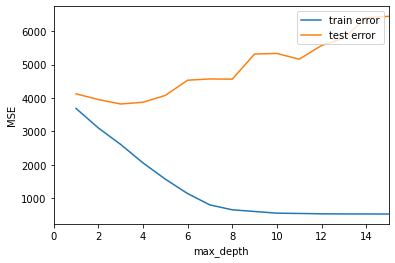

In [11]:
n_trees = 10 # 10 деревьев показали хороший результат из теста выше, 
             #именно в районе 10 дерьев, ошибка на тесте выходит на ассимптоту.
max_depth = np.arange(1, 16, 1) # Рассмотрим глубину от 1 до 15.
eta = 0.2
error_train_max_depth = []
error_test_max_depth = []

for i in max_depth:
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, eta)
    error_test_max_depth.append(test_errors[-1])
    error_train_max_depth.append(train_errors[-1])
    
        
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.xlim(0, max_depth[-1])
plt.plot(max_depth, error_train_max_depth, label='train error')
plt.plot(max_depth, error_test_max_depth, label='test error')
plt.legend(loc='upper right')
plt.show();

Наименьший показатель ошибка на тесте вышел на глубину дерьевей равной двум/трём, далее же ошибка резко начинает увеличиваться, так как с увеличением глубины деревьев в бустинге, они начинают замечать все больше особенностей и зависимостей на тренировочных данных, что приводит к переобучению модели в целом.

### Задание 2.
*Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

In [12]:
from numpy.random import random_sample

In [13]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, size=0.5):
    
    
    trees = []
    ## ИЗМЕНЕНИЕ определяем количество объектов для выборки из тренировочных данных
    size = int(np.floor(size*X_train.shape[0])) 
    
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    
        # ИЗМЕНЕНИЕ берем случайные индексы из X_train в количестве = size
        sample_index = np.random.randint(0, X_train.shape[0], size=size)

        
        if len(trees) == 0:
            # ИЗМЕНЕНИЕ обучаем только на выборочных тренировочных данных
            tree.fit(X_train[sample_index], y_train[sample_index]) 
            
            # А сравниваем результаты на всех данных:
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            target = gb_predict(X_train, trees, eta)
            
            # ИЗМЕНЕНИЕ обучаем только на выборочных тренировочных данных
            tree.fit(X_train[sample_index], residual(y_train, target)[sample_index])
            
            # А сравниваем результаты на всех данных:
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

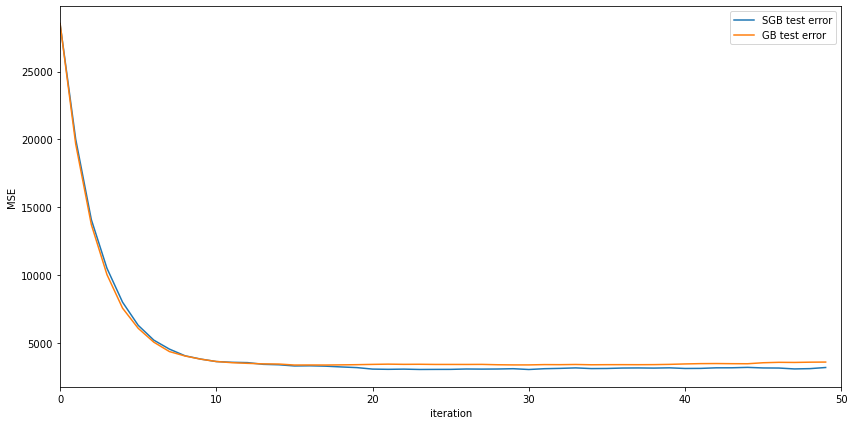

CPU times: user 974 ms, sys: 39.2 ms, total: 1.01 s
Wall time: 1.11 s


In [14]:
%%time
n_trees = 50
max_depth = 3
eta = 0.2

sgb_trees, sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, 
                                                       y_train, y_test, eta, size=0.5)
gb_trees, gb_train_errors, gb_test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

plt.figure(figsize = (14, 7))

plt.xlabel('iteration')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(sgb_test_errors, label='SGB test error')
plt.plot(gb_test_errors, label='GB test error')
plt.legend(loc='upper right')
plt.show();

Как видим, SGB практически не уступает GB в ошибке, скорость обучения такая же, но потреблено меньше ресурсов. В некоторых случаях, SGB даже показывает лучший результат, из-за того что не улавливает ошибочных закономерностей, которые уловила GB, обучаясь на всех данных.